# Multivariate Linear Models

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import statsmodels.api as smf

import warnings
warnings.filterwarnings("ignore")

### Easy

###### 5E1

Which of the linear models below are multiple linear regressions?  
1. $\mu_i = \alpha + \beta x_i$
1. $\mu_i = \beta_x x_i + \beta_z z_i$
1. $\mu_i = \alpha + \beta (x_i - z_i)$
1. $\mu_i = \alpha + \beta_x x_i + \beta_z z_i$

**Answer:**
1. No. Regression only on $x_i$  
1. Yes  
1. No. Difference of $x_i$ and $z_i$ results in only 1 variable.  
1. Yes

###### 5E2

Write down a multiple regression to evaluate the claim: *Animal diversity is linearly related to latitute, but only after controlling for plant diversity*. You just need to write down the model definition.

**Answer:**  
$$
\begin{align}
\text{Animal Diversity} &\sim \text{Normal($\mu_i$, $\sigma_i$)} \\
\mu_i &= \beta_1 \text{ Latitude}_i +  \beta_2 \text{ Plant_Diversity}_i\\
\beta_1 &\sim \text{Normal(0, 10)} \\
\beta_2 &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform(0, 50)} \\
\end{align}
$$

###### 5E3

Write down a multiple regression to evaluate the claim: *Neither amount of funding now size of labratory is by itself a good predictor of time to PhD degree; but together these variables are both positively associated with time to degree*. Write down the model definition and indicate which side of zero each slope parameter should be on.

**Answer:**  
$$
\begin{align}
\text{Time to PhD Degree} &\sim \text{Normal($\mu_i$, $\sigma_i$)} \\
\mu_i &= \beta_1 \text{ Lab_size}_i +  \beta_2 \text{ Funding}_i\\
\beta_1 &\sim \text{Normal(0, 10)} \\
\beta_2 &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform(0, 50)} \\
\end{align}
$$

We expect both beta parameters to not be equal to zero. One hypothesis could be that both parameters are negative since a larger lab (more people to help) and larger funding could imply faster time to PhD degree.

###### 5E4

Suppose you have a single categorical predictor with 4 levels (unique values), labeled A, B, C, and D. Let A$_i$ be an indicator variable that is 1 where case *i* is in category A. Also suppose B$_i$, C$_i$, and D$_i$ for the other categories. Now which of the following linear models are inferentially equivalent ways to include the categorical variable in a regression? Models are inferentially equivalent when it's possible to compute one posterior distribution from the posterior distribution of another model.

1. $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_D D_i$  
1. $\mu_i = \alpha + \beta_A A_i + \beta_B B_i + \beta_C C_i + \beta_D D_i$  
1. $\mu_i = \alpha + \beta_B B_i + \beta_C C_i + \beta_D D_i$  
1. $\mu_i = \alpha_A A_i  + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$  
1. $\mu_i = \alpha_A (1 - B_i - C_i - D_i) + \alpha_B B_i + \alpha_C C_i + \alpha_D D_i$  

Models 1, 3, 4 and 5 are inferentially equivalent.

### Medium

###### 5M1

Invent your own example of a spurious correlation. An outcome variable should be correlated with both predictor variables. But when both predictors are entered in the same model, the correlation between the outcome and one of the predictors should mostly vanish (or at least be greatly reduced).

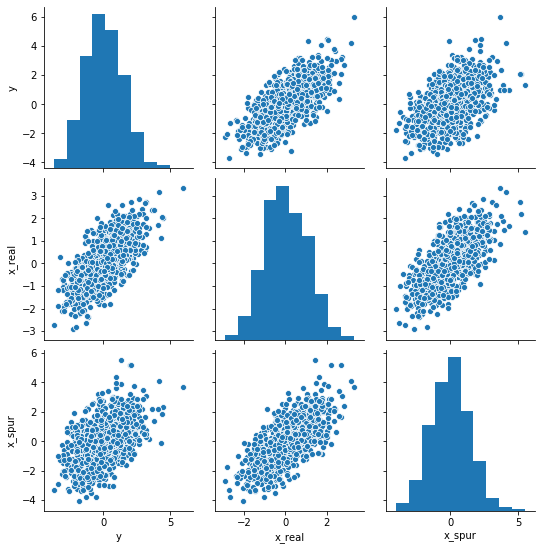

In [2]:
N = 1000
x_real = np.random.normal(size=N)
x_spur = np.random.normal(x_real)
y = np.random.normal(x_real)

d = pd.DataFrame([y, x_real, x_spur], index=['y', 'x_real', 'x_spur']).T

sns.pairplot(d);

In [3]:
with pm.Model() as m5_m1a:
    sigma = pm.Uniform('sigma',lower=0, upper=50)
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=1)
    mu = pm.Deterministic('mu', a + b * d.x_spur)
    y_pred = pm.Normal('y', mu=mu, sd=sigma, observed=d.y)
    trace_5_m1a = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_m1a, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1114.53draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.062,0.039,0.002,0.128
b,0.499,0.027,0.455,0.541
sigma,1.207,0.027,1.165,1.249


In [4]:
with pm.Model() as m5_m1b:
    sigma = pm.Uniform('sigma',lower=0, upper=50)
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=1, shape=2)
    mu = pm.Deterministic('mu', a + b[0] * d.x_spur + b[1] * d.x_real)
    y_pred = pm.Normal('y', mu=mu, sd=sigma, observed=d.y)
    trace_5_m1b = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_m1b, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:05<00:00, 775.52draws/s] 


,mean,sd,hpd_5.5%,hpd_94.5%
a,0.012,0.031,-0.041,0.059
b[0],0.022,0.029,-0.024,0.067
b[1],0.949,0.042,0.885,1.016
sigma,0.986,0.023,0.947,1.021


###### 5M2

Invent your own example of a masked relationship. An outcome variable should be correlated with both predictor variables, but in opposite directions. And the two predictor variables should be correlated with one another.

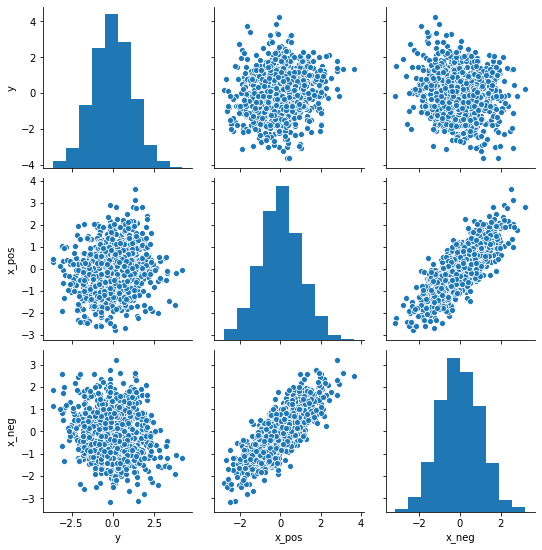

In [5]:
N = 1000
rho = 0.8
x_pos = np.random.normal(size=N)
x_neg = np.random.normal(rho*x_pos, (1-rho**2)**0.5)
y = np.random.normal(x_pos - x_neg)

d = pd.DataFrame([y, x_pos, x_neg], index=['y', 'x_pos', 'x_neg']).T

sns.pairplot(d);

In [6]:
with pm.Model() as m5_m2:
    sigma = pm.Uniform('sigma',lower=0, upper=50)
    a = pm.Normal('a', mu=0, sd=10)
    b = pm.Normal('b', mu=0, sd=1, shape=2)
    mu = pm.Deterministic('mu', a + b[0] * d.x_pos + b[1] * d.x_neg)
    y_pred = pm.Normal('y', mu=mu, sd=sigma, observed=d.y)
    trace_5_m2 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_m2, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1034.85draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,-0.041,0.032,-0.090,0.010
b[0],1.015,0.053,0.928,1.099
b[1],-1.026,0.054,-1.111,-0.938
sigma,1.018,0.022,0.982,1.055


###### 5M3

It is sometimes observed that the best predictor of fire risk is the presence of firefighters - States and localities with many firefighters also have more fires. Presumably firefightes do not *cause* fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorice and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship, using multiple regression?

**Answer:** Individuals who have divorced may go on to re-marry (maybe multiple times), meaning a high divorce rate could lead to high marriage rates. One way to check this relationship would be to see if divorce rates are a function of marriage age and number of past marriages.

###### 5M4

In the divorce data, States with high numbers of Mormons have much lower divorce rates than the regression models expected. Find a list of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.


In [7]:
lds = pd.read_csv('../../data/Mormon.csv')
lds.columns = ['Location', 'MormonPop', 'StatePop', 'PercMormon']
lds = lds[['Location', 'PercMormon']]

d = pd.read_csv('../../data/WaffleDivorce.csv', sep=';')

d = (
    pd.merge(d, lds, how='left', on='Location')
    .assign(PercMormon_s = lambda x: (x.PercMormon - x.PercMormon.mean()) / x.PercMormon.std(),
            Marriage_s = lambda x: (x.Marriage - x.Marriage.mean()) / x.Marriage.std(),
            MedianAgeMarriage_s = lambda x: (x.MedianAgeMarriage - x.MedianAgeMarriage.mean()) / x.MedianAgeMarriage.std()
           )
)

with pm.Model() as m_5m_4:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('a', mu=10, sd=10)
    b = pm.Normal('b', mu=0, sd=1, shape=3)
    mu = pm.Deterministic('mu', a + b[0] * d.Marriage_s + b[1] * d.MedianAgeMarriage_s + b[2] * d.PercMormon_s)
    Divorce = pm.Normal('divorce', mu=mu, sd=sigma, observed=d.Divorce)
    trace_5_m4 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5_m4, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1087.34draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
a,9.695,0.198,9.376,9.999
b[0],0.070,0.303,-0.398,0.555
b[1],-1.256,0.299,-1.691,-0.754
b[2],-0.573,0.234,-0.902,-0.148
sigma,1.438,0.159,1.188,1.676


###### 5M5

One way to reason through multiple causation hypotheses is to imagine detailed mechanisms through which predictor variables may influence outcomes. For example, it is sometimes argued that the price of gasoline (predictor variable) is positiviely associated with lower obesity rates (outcome variable). However, there are at least two important mechanisms by which the price of gas could reduce obesity. First, it could lead to less driving and therefore more exercise. Second, it could lead to less driving, which leads to less eating out, which leads to less consumption of huge restaurant meals. Can you outline one or more multiple regressions that address these two mechanisms? Assume you can have any predictor data you need.

**Answer:**  
Mechanism 1:
$$
\begin{align}
\text{Obesity rate} &\sim \text{Normal($\mu_i$, $\sigma_i$)} \\
\mu_i &= \alpha + \beta_1 \text{ Gasoline_price}_i +  \beta_2 \text{ Hours_driving_per_day_per_person}_i\\
\alpha &\sim \text{Normal(30, 20)} \\
\beta_1 &\sim \text{Normal(0, 10)} \\
\beta_2 &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform(0, 50)} \\
\end{align}
$$

Mechanism 2:
$$
\begin{align}
\text{Obesity rate} &\sim \text{Normal($\mu_i$, $\sigma_i$)} \\
\mu_i &= \alpha + \beta_1 \text{ Gasoline_price}_i +  \beta_2 \text{ restaurant_meals_per_year_per_person}_i\\
\alpha &\sim \text{Normal(30, 20)} \\
\beta_1 &\sim \text{Normal(0, 10)} \\
\beta_2 &\sim \text{Normal(0, 10)} \\
\sigma &\sim \text{Uniform(0, 50)} \\
\end{align}
$$

### Hard

All three exercises below use the same data, `data(foxes)` (part of `rethinking`). The urban fox (*Vulpes vulpes*) is a successful exploiter of human habitat. Since urbran foxes move in packs and defend territories, data on haitat quality and population density is also included. The data frame has fix columns:

1. `group`: Number of the social group the individual fox belongs to
1. `avgfood`: The average amount of food available in the territory
1. `groupsize`: The number of foxes in the social group
1. `area`: Size of the territory
1. `weight`: Body weight of the individual fox


In [8]:
d = pd.read_csv('../../data/foxes.csv', sep=';')
d = (
    d
    .assign(area_s = lambda x: (x.area - x.area.mean()) / x.area.std(),
            groupsize_s = lambda x: (x.groupsize - x.groupsize.mean()) / x.groupsize.std(),
            avgfood_s = lambda x: (x.avgfood - x.avgfood.mean()) / x.avgfood.std()
           )
)
d.head()

,group,avgfood,groupsize,area,weight,area_s,groupsize_s,avgfood_s
0,1,0.37,2,1.09,5.02,-2.239596,-1.524089,-1.924829
1,1,0.37,2,1.09,2.84,-2.239596,-1.524089,-1.924829
2,2,0.53,2,2.05,5.33,-1.205508,-1.524089,-1.118035
3,2,0.53,2,2.05,6.07,-1.205508,-1.524089,-1.118035
4,3,0.49,2,2.12,5.85,-1.130106,-1.524089,-1.319734


###### 5H1

Fit two bivariate Gaussian regressions, using map:  
1. body weight as a linear function of territory size (area), and
1. body weight as a linear function of groupsize.  

Plot the results of these regressions, displaying the MAP regression line and 95\% interval of the mean. Is either variable important for predicting fox body weight?


In [9]:
# body weight as a linear function of territory size (area)
with pm.Model() as m_5h_1a:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('alpha', mu=10, sd=10)
    b = pm.Normal('b_area', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + b * d.area_s)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d.weight)
    trace_5h_1a = pm.sample(1000, tune=1000)

# body weight as a linear function of groupsize
with pm.Model() as m_5h_1b:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('alpha', mu=10, sd=10)
    b = pm.Normal('b_size', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + b * d.groupsize_s)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d.weight)
    trace_5h_1b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_area, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1810.17draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_size, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1629.21draws/s]


In [10]:
pm.stats.summary(trace_5h_1a, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,4.531,0.119,4.339,4.721
b_area,0.025,0.116,-0.166,0.208
sigma,1.201,0.083,1.055,1.315


In [11]:
pm.stats.summary(trace_5h_1b, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,4.529,0.111,4.350,4.702
b_size,-0.194,0.110,-0.363,-0.019
sigma,1.189,0.084,1.052,1.317


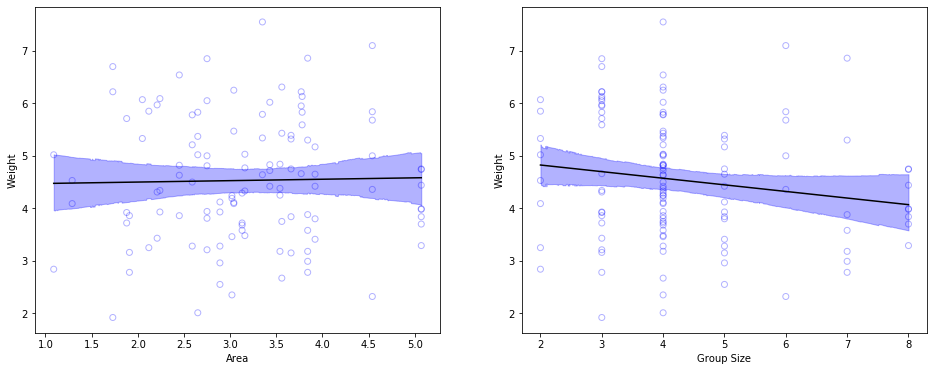

In [12]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

area_seq = np.linspace(d.area_s.min(), d.area_s.max(), 1000)
x_labels_1 = d.area.std() * area_seq + d.area.mean()
mu_pred_1 = trace_5h_1a['alpha'] + trace_5h_1a['b_area'] * area_seq[:,None]
ax1.scatter(d.area, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(d.area, trace_5h_1a['mu'].mean(axis=0), ax=ax1, ci=None, color='k')
ax1.fill_between(x_labels_1,
                 pm.stats.hpd(mu_pred_1.T)[:,0], pm.stats.hpd(mu_pred_1.T)[:,1],
                 alpha=.3, color='b')
ax1.set_xlabel('Area')
ax1.set_ylabel('Weight')

group_seq = np.linspace(d.groupsize_s.min(), d.groupsize_s.max(), 1000)
x_labels_2 = d.groupsize.std() * group_seq + d.groupsize.mean()
mu_pred_2 = trace_5h_1b['alpha'] + trace_5h_1b['b_size'] * group_seq[:,None]
ax2.scatter(d.groupsize, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(d.groupsize, trace_5h_1b['mu'].mean(axis=0), ax=ax2, ci=None, color='k')
ax2.fill_between(x_labels_2,
                 pm.stats.hpd(mu_pred_2.T)[:,0], pm.stats.hpd(mu_pred_2.T)[:,1],
                 alpha=.3, color='b')
ax2.set_xlabel('Group Size')
ax2.set_ylabel('Weight');

We can see that the beta coefficient for both variable has zero in its interval. Furthermore, the plots also indicate very little relationship between the variables and weight.

###### 5H2

Now fit a multiple linear regression with weight as the outcome and both area and groupsize as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor constant at its mean. What does this model say about the importance of each variable? Why do you get different results than you got in the exercise above?


In [13]:
with pm.Model() as m_5h_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('alpha', mu=0, sd=100)
    b1 = pm.Normal('b_area', mu=0, sd=100)
    b2 = pm.Normal('b_size', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + b1 * d.area_s + b2 * d.groupsize_s)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d.weight)
    trace_5h_2 = pm.sample(1000, tune=1000)

pm.stats.summary(trace_5h_2, credible_interval=0.89, varnames=['~mu'], kind='stats')

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_size, b_area, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1346.38draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
alpha,4.531,0.109,4.366,4.707
b_area,0.567,0.194,0.253,0.864
b_size,-0.661,0.191,-0.971,-0.369
sigma,1.147,0.076,1.018,1.260


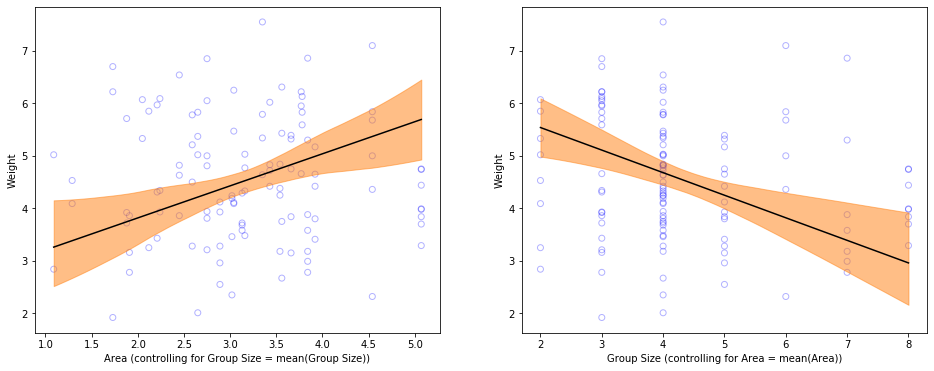

In [14]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

area_seq = np.linspace(d.area_s.min(), d.area_s.max(), 1000)
x_labels_1 = d.area.std() * area_seq + d.area.mean()
mu_pred_1 = trace_5h_2['alpha'] + trace_5h_2['b_area'] * area_seq[:,None]
ax1.scatter(d.area, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_1, mu_pred_1.mean(axis=1), ax=ax1, ci=None, color='k')
pm.plot_hpd(x_labels_1, mu_pred_1.T, ax=ax1)
ax1.set_xlabel('Area (controlling for Group Size = mean(Group Size))')
ax1.set_ylabel('Weight')

group_seq = np.linspace(d.groupsize_s.min(), d.groupsize_s.max(), 1000)
x_labels_2 = d.groupsize.std() * group_seq + d.groupsize.mean()
mu_pred_2 = trace_5h_2['alpha'] + trace_5h_2['b_size'] * group_seq[:,None]
ax2.scatter(d.groupsize, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_2, mu_pred_2.mean(axis=1), ax=ax2, ci=None, color='k')
pm.plot_hpd(x_labels_2, mu_pred_2.T, ax=ax2)
ax2.set_xlabel('Group Size (controlling for Area = mean(Area))')
ax2.set_ylabel('Weight');

We can see that controlling for one variable, the correlation of the other variable on the weight increases. This implies that there is some masked relationship between area and group size. The results are must better as one can hypothesize that:
1. Controlling for group size, as the area of territory increases, a fox might get more food and, therefore, increase its weight
1. Controlling for area, as the group size increases, the amount of food available per fox reduces. This can lead to lower weight.

Hence, area and group size can together have an explanatory power on weight

###### 5H3

Finally, consider the avgfood variable. Fit two more multiple regressions: 
1. body weight as an additive function of avgfood and groupsize, and 
2. body weight as an additive function of all three variables, avgfood and groupsize and area.  

In [15]:
# body weight as an additive function of avgfood and groupsize
with pm.Model() as m_5h_1a:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('alpha', mu=0, sd=100)
    b1 = pm.Normal('b_food', mu=0, sd=100)
    b2 = pm.Normal('b_size', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + b1 * d.avgfood_s + b2 * d.groupsize_s )
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d.weight)
    trace_5h_3a = pm.sample(1000, tune=1000)

# body weight as an additive function of all three variables, avgfood and groupsize and area
with pm.Model() as m_5h_1b:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    a = pm.Normal('alpha', mu=0, sd=100)
    b1 = pm.Normal('b_food', mu=0, sd=100)
    b2 = pm.Normal('b_size', mu=0, sd=100)
    b3 = pm.Normal('b_area', mu=0, sd=100)
    mu = pm.Deterministic('mu', a + b1 * d.avgfood_s + b2 * d.groupsize_s + b3 * d.area_s)
    weight = pm.Normal('weight', mu=mu, sd=sigma, observed=d.weight)
    trace_5h_3b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_size, b_food, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 988.08draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_area, b_size, b_food, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:04<00:00, 822.03draws/s]


Compare the results of these models to the previous models you've fit, in the first two exercises. 
1. Is avgfood or area a better predictor of body weight? If you had to choose one or the other to include in a model, which would it be? Support your assessment with any tables or plots you choose. 

**Answer:** Looking at the plots of Area and AvgFood vs Weight (while controlling for Group Size), we can see that Avg Food available in the territory has a higher correlation with weight. This is also evidenced in the summary tables. Therefore, Avg Food would be a better predictor for weight.

However, it should be noted that the distribution of `b_food` is a lot wider than `b_area`, indicating that there is higher uncertainty about the effect of Avg Food on weight when controlling for Group Size.

In [16]:
pm.stats.summary(trace_5h_3a, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,4.530,0.103,4.363,4.689
b_food,0.751,0.248,0.389,1.192
b_size,-0.865,0.246,-1.270,-0.483
sigma,1.145,0.076,1.027,1.264


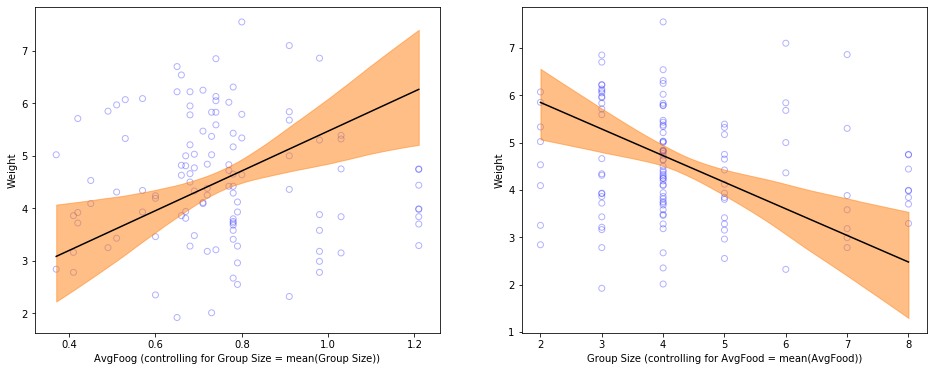

In [17]:
_, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

food_seq = np.linspace(d.avgfood_s.min(), d.avgfood_s.max(), 1000)
x_labels_1 = d.avgfood.std() * food_seq + d.avgfood.mean()
mu_pred_1 = trace_5h_3a['alpha'] + trace_5h_3a['b_food'] * food_seq[:,None]
ax1.scatter(d.avgfood, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_1, mu_pred_1.mean(axis=1), ax=ax1, ci=None, color='k')
pm.plot_hpd(x_labels_1, mu_pred_1.T, ax=ax1)
ax1.set_xlabel('AvgFoog (controlling for Group Size = mean(Group Size))')
ax1.set_ylabel('Weight')

group_seq = np.linspace(d.groupsize_s.min(), d.groupsize_s.max(), 1000)
x_labels_2 = d.groupsize.std() * group_seq + d.groupsize.mean()
mu_pred_2 = trace_5h_3a['alpha'] + trace_5h_3a['b_size'] * group_seq[:,None]
ax2.scatter(d.groupsize, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_2, mu_pred_2.mean(axis=1), ax=ax2, ci=None, color='k')
pm.plot_hpd(x_labels_2, mu_pred_2.T, ax=ax2)
ax2.set_xlabel('Group Size (controlling for AvgFood = mean(AvgFood))')
ax2.set_ylabel('Weight');

1. When both avgfood or area are in the same model, their effects are reduced (closer to zero) and their standard errors are larger than when they are included in separate models. Can you explain this result?

**Answer:** This reduced effect can be seen in the summary table below. The effect of Avg Food and Area could be reduced as they may be causing multicollinearity within the data. We can see that the correlation between the two variables this high, at 0.88. It could be that as the area of the territory increases, the average food available increases. Therefore, knowing the quantity of Average Food available already tells us about the size of the territory.

In [18]:
pm.stats.summary(trace_5h_3b, credible_interval=0.89, varnames=['~mu'], kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,4.535,0.112,4.353,4.705
b_food,0.497,0.283,0.063,0.956
b_size,-0.938,0.243,-1.318,-0.544
b_area,0.364,0.220,0.025,0.718
sigma,1.134,0.077,1.014,1.249


In [19]:
d[['area', 'avgfood']].corr().iloc[0,1]

0.8831037822794561

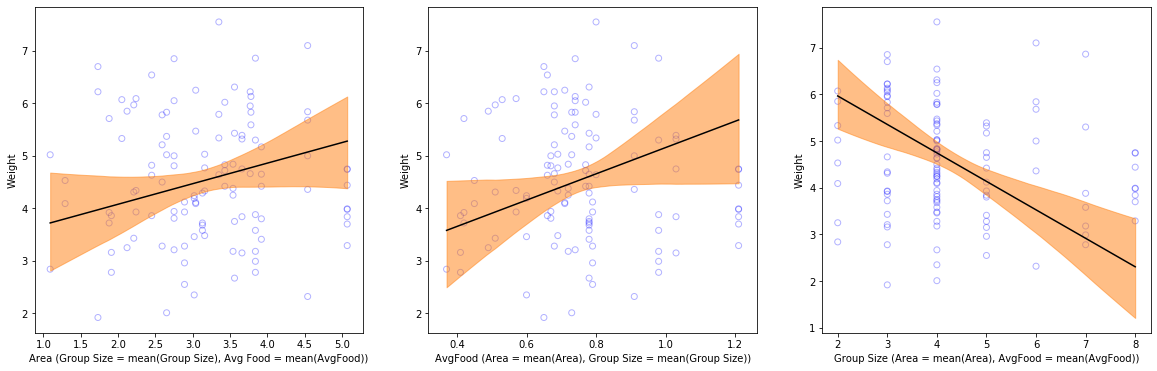

In [20]:
_, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20, 6))

area_seq = np.linspace(d.area_s.min(), d.area_s.max(), 1000)
x_labels_1 = d.area.std() * area_seq + d.area.mean()
mu_pred_1 = trace_5h_3b['alpha'] + trace_5h_3b['b_area'] * area_seq[:,None]
ax1.scatter(d.area, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_1, mu_pred_1.mean(axis=1), ax=ax1, ci=None, color='k')
pm.plot_hpd(x_labels_1, mu_pred_1.T, ax=ax1)
ax1.set_xlabel('Area (Group Size = mean(Group Size), Avg Food = mean(AvgFood))')
ax1.set_ylabel('Weight')

food_seq = np.linspace(d.avgfood_s.min(), d.avgfood_s.max(), 1000)
x_labels_2 = d.avgfood.std() * food_seq + d.avgfood.mean()
mu_pred_2 = trace_5h_3b['alpha'] + trace_5h_3b['b_food'] * food_seq[:,None]
ax2.scatter(d.avgfood, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_2, mu_pred_2.mean(axis=1), ax=ax2, ci=None, color='k')
pm.plot_hpd(x_labels_2, mu_pred_2.T, ax=ax2)
ax2.set_xlabel('AvgFood (Area = mean(Area), Group Size = mean(Group Size))')
ax2.set_ylabel('Weight')

group_seq = np.linspace(d.groupsize_s.min(), d.groupsize_s.max(), 1000)
x_labels_3 = d.groupsize.std() * group_seq + d.groupsize.mean()
mu_pred_3 = trace_5h_3b['alpha'] + trace_5h_3b['b_size'] * group_seq[:,None]
ax3.scatter(d.groupsize, d.weight, facecolors='none', edgecolors='b', alpha=0.3)
sns.lineplot(x_labels_3, mu_pred_3.mean(axis=1), ax=ax3, ci=None, color='k')
pm.plot_hpd(x_labels_3, mu_pred_3.T, ax=ax3)
ax3.set_xlabel('Group Size (Area = mean(Area), AvgFood = mean(AvgFood))')
ax3.set_ylabel('Weight');

In [21]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1
Arviz 0.6.1


